### This notebook is used to train unimodal LSTM autoencoders and save the encoded representation. It also computes the FV from the encoded representation, performs feature selection and Random Forest Classification.

In [1]:
import numpy as np
from scipy import stats
import pickle
from os import listdir
import os 
from os.path import isfile, join
from scipy.signal import savgol_filter
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import os
import cv2
import os
import json
import itertools as it
import keras
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Masking
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.utils import plot_model
from keras import optimizers
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GMM

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# read and threshold output.
# if less or eq to 7 put 0 (not depressed)
# else put 1 
DATA_PATH = "TemporalData60"
DATA_PATH2 = "FINAL_RESULTS_60"
onlyfiles = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
x_train = list()
x_train_length = list()
y_train = list()

for i in range(len(onlyfiles)):
    tmp =  np.load(os.path.join(DATA_PATH, onlyfiles[i]))
    x_train.append(tmp)
    x_train_length.append(tmp.shape[0])
    label = tmp[0,0,-1]
    if (label <= 7):
        y_train.append(0)
    else:
        y_train.append(1)
        
        
print (len(x_train))
print (len(x_train_length))
print (len(y_train))


64
64
64


In [3]:
X = np.vstack((x_train))
print ("Shape of data for autoencoder is ", X.shape)

Shape of data for autoencoder is  (710102, 60, 66)


In [4]:
#subset the relevant features
feature_type = "mfcc"
if (feature_type == "fidget"):
    X = X[:,:,:-1]
    X = X[:,:,:9]
elif (feature_type == "gaze"):

    X = X[:,:,:-1]
    X = X[:,:,9:17]
elif (feature_type == "au"):

    X = X[:,:,:-1]
    X = X[:,:,17:52]
else:
   
    X = X[:,:,:-1]
    X = X[:,:,52:]
        
    
print ("Shape of unimodal data for autoencoder is ", X.shape)


Shape of unimodal data for autoencoder is  (710102, 60, 13)


In [5]:
#MODEL DEFINITION
hidden_ratio = 0.4
timesteps, n_features = X.shape[1] , X.shape[2]
dimensions_lstm = round(n_features*hidden_ratio)
print ('Hidden dimension %i' %dimensions_lstm)
# encoder part
# input placeholder
input_data = Input(shape=(timesteps, n_features))
encoded = Bidirectional(LSTM(dimensions_lstm, activation='relu', return_sequences=False))(input_data)
#connection between encoder and decoder
middle_representation = RepeatVector(timesteps)(encoded)
# decoder part
decoded = Bidirectional(LSTM(dimensions_lstm, activation='relu', return_sequences=True))(middle_representation)
decoded = TimeDistributed(Dense(n_features, activation = 'linear'))(decoded)
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)
autoencoder.compile(loss='mae', optimizer="adam")
print("--" * 20)
print("autoencoder")
print(autoencoder.summary())
print("--" * 20)
print("encoder")
print(encoder.summary())

Hidden dimension 5
Instructions for updating:
Colocations handled automatically by placer.
----------------------------------------
autoencoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 13)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10)                760       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 60, 10)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 10)            640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 13)            143       
Total params: 1,543
Trainable params: 1,543
Non-trainable params: 0
______________________________________________________________

In [6]:
save_dir = 'FINAL_RESULTS_60'
save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print("Directory " , save_dir ,  " Created ")
else:    
    print("Directory " , save_dir ,  " already exists")

Directory  FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4  Created 


In [7]:
from keras.callbacks import EarlyStopping
csv_logger = CSVLogger(os.path.join(save_dir, "logger.csv"))
checkpoint = ModelCheckpoint(os.path.join(save_dir, "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"), 
                             monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_logger, checkpoint]

hist = autoencoder.fit(X, X, epochs=20,
                batch_size=5120,
                callbacks=callbacks_list, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
710102/710102 [==============================] - 45s 63us/step - loss: 23.0365

Epoch 00001: loss improved from inf to 23.03653, saving model to FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/weights-improvement-01-23.04.hdf5
Epoch 2/20
710102/710102 [==============================] - 34s 47us/step - loss: 3.9685

Epoch 00002: loss improved from 23.03653 to 3.96849, saving model to FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/weights-improvement-02-3.97.hdf5
Epoch 3/20
710102/710102 [==============================] - 45s 63us/step - loss: 2.8865

Epoch 00003: loss improved from 3.96849 to 2.88653, saving model to FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/weights-improvement-03-2.89.hdf5
Epoch 4/20
710102/710102 [==============================] - 34s 48us/step - loss: 3.7576

Epoch 00004: loss did not improve from 2.88653
Epoch 5/20
710102/710102 [==============================] - 49s 69us/step - loss: 3.2959

Epoch

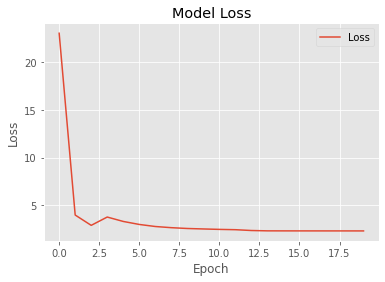

In [8]:
plt.style.use('ggplot')
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.savefig(os.path.join(save_dir, 'LOSS.png'))
plt.show()

In [9]:
autoencoder.save_weights(os.path.join(save_dir, 'BI_LSTM_DYNAMICS.h5'))
#autoencoder.load_weights(os.path.join(save_dir, 'BI_LSTM_DYNAMICS.h5'))

In [10]:
print ('Encoding representation')
encoded_train = encoder.predict(X)
print ('Encoding done!')

Encoding representation
Encoding done!


In [11]:
encoded_dir = 'FINAL_RESULTS_60'
encoded_dir = encoded_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)+'/encoding'
if not os.path.exists(encoded_dir):
    os.mkdir(encoded_dir)
    print("Directory " , encoded_dir ,  " Created ")
else:    
    print("Directory " , encoded_dir ,  " already exists")
    
np.save(os.path.join(encoded_dir, 'encoded_train'), encoded_train)

Directory  FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/encoding  Created 


In [12]:
def fisher_vector(xx, gmm, normalized=True):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covars_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    fisher =  np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))
    if normalized:
            fisher = np.sqrt(np.abs(fisher)) * np.sign(fisher) # power normalization
            fisher = fisher / np.linalg.norm(fisher, axis=0) # L2 norm
            
    return fisher

In [13]:
def frame2session(encoded_dir, x_train_length):
    
    tmp = list()
    X_train_frame = np.load(encoded_dir + "/encoded_train.npy")
    indices = np.zeros((len(x_train_length)+1))
    indices[0] = 0
    for i in range(1, len(x_train_length)):
        indices[i] = indices[i-1] + x_train_length[i-1]
    indices[len(x_train_length)] = sum(x_train_length)-1 
    for i in range(len(indices)-1):
        tmp.append(X_train_frame[int(indices[i]):int(indices[i+1]),:])
        
    return tmp

In [14]:
X_frame_train = frame2session(encoded_dir, x_train_length)
print (len(X_frame_train))


64


In [15]:
import warnings
warnings.filterwarnings(action='once')

    
save_dir = 'FINAL_RESULTS_60'
save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)+'/fisherVectors'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print("Directory " , save_dir ,  " Created ")
else:    
    print("Directory " , save_dir ,  " already exists")
    
    
kernels = [16 , 32]
for kernel in kernels:
    
    print ('Computing kernel %i' %kernel)
    fv_train, fv_dev = [], []

    for X_train in X_frame_train:
        gmm = GMM(n_components=kernel, covariance_type='diag')
        gmm.fit(X_train)
        fv = fisher_vector(X_train, gmm)
        fv_train.append(fv)

    np.save(os.path.join(save_dir, 'fisher_vector_train_%i' %kernel), fv_train)


Directory  FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/fisherVectors  Created 
Computing kernel 16


/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


Computing kernel 32


In [16]:
#feature selection
kernels = [16, 32]
feat_numbers = [50, 100, 150, 200, 250, 300]

for kernel in kernels:
    for feat_number in feat_numbers:
        save_dir = 'FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)+'/fisherVectors'

        X_train = np.load(os.path.join(save_dir, 'fisher_vector_train_%i.npy' %kernel))
        

        print (X_train.shape)
        print (len(y_train))
        
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=800, criterion='entropy')
        df = pd.DataFrame(X_train)
        y = y_train
        feature_names = ['feature_%d' % i for i in range(len(X_train[0]))]
        df.columns = feature_names
        print(df.head())

        model.fit(df, y)
        importances = model.feature_importances_
        print("\nfeature importance ranking")
        indices = np.argsort(importances)[::-1]
        for f in range(100):
            print("%d. feature %d %s (%f)" % (f+1, indices[f], feature_names[indices[f]], importances[indices[f]]))
        indices = indices[:feat_number]
        #np.save(os.path.join(save_dir, 'feature_list_%d' % 32), indices)

        X_train_df = pd.DataFrame(X_train)
        X_train_df.columns = ['feature_%d' % i for i in range(len(X_train[0]))]
        X_train_tree = X_train_df.iloc[:, indices]

       

        print(X_train_tree.shape)

        save_dir = 'FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)

        np.save(os.path.join(save_dir, 'X_train_tree_%i_%i' %(kernel, feat_number)), X_train_tree)

        

(64, 336)
64
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.003196   0.016818   0.037713   0.044312  -0.020322   0.028315   
1   0.053181   0.046687   0.042593  -0.033030  -0.074276   0.034757   
2   0.033206   0.017512  -0.025823  -0.054084  -0.024345   0.042596   
3  -0.025786   0.078076  -0.054355  -0.028245  -0.052873   0.034688   
4  -0.029932   0.062247  -0.080130   0.043698   0.071922  -0.058681   

   feature_6  feature_7  feature_8  feature_9  ...  feature_326  feature_327  \
0  -0.069711   0.035199   0.033197   0.013107  ...     0.050233     0.019413   
1   0.087899  -0.046566  -0.036739  -0.030427  ...     0.015559     0.008920   
2   0.016318  -0.003803  -0.024744  -0.077192  ...     0.069301     0.027037   
3  -0.016117   0.052303   0.021985  -0.068788  ...     0.023310    -0.007083   
4   0.062502  -0.033216  -0.038009  -0.086980  ...     0.043495     0.027045   

   feature_328  feature_329  feature_330  feature_331  feature_332  \
0     0.0


feature importance ranking
1. feature 151 feature_151 (0.014123)
2. feature 118 feature_118 (0.014120)
3. feature 125 feature_125 (0.013533)
4. feature 102 feature_102 (0.012447)
5. feature 62 feature_62 (0.011317)
6. feature 147 feature_147 (0.009315)
7. feature 24 feature_24 (0.009314)
8. feature 225 feature_225 (0.008963)
9. feature 113 feature_113 (0.008855)
10. feature 158 feature_158 (0.008306)
11. feature 167 feature_167 (0.008275)
12. feature 14 feature_14 (0.008054)
13. feature 311 feature_311 (0.007963)
14. feature 236 feature_236 (0.007946)
15. feature 38 feature_38 (0.007709)
16. feature 262 feature_262 (0.007085)
17. feature 48 feature_48 (0.006838)
18. feature 95 feature_95 (0.006725)
19. feature 226 feature_226 (0.006706)
20. feature 333 feature_333 (0.006424)
21. feature 19 feature_19 (0.006417)
22. feature 92 feature_92 (0.006310)
23. feature 76 feature_76 (0.006288)
24. feature 144 feature_144 (0.006122)
25. feature 332 feature_332 (0.006050)
26. feature 228 feature_


feature importance ranking
1. feature 118 feature_118 (0.013843)
2. feature 147 feature_147 (0.012683)
3. feature 24 feature_24 (0.011028)
4. feature 125 feature_125 (0.010660)
5. feature 102 feature_102 (0.010611)
6. feature 236 feature_236 (0.009529)
7. feature 189 feature_189 (0.009009)
8. feature 151 feature_151 (0.008997)
9. feature 38 feature_38 (0.008652)
10. feature 14 feature_14 (0.008348)
11. feature 228 feature_228 (0.008306)
12. feature 262 feature_262 (0.008297)
13. feature 167 feature_167 (0.008238)
14. feature 19 feature_19 (0.007797)
15. feature 62 feature_62 (0.007642)
16. feature 113 feature_113 (0.007500)
17. feature 48 feature_48 (0.007442)
18. feature 165 feature_165 (0.007163)
19. feature 225 feature_225 (0.006835)
20. feature 311 feature_311 (0.006765)
21. feature 141 feature_141 (0.006711)
22. feature 144 feature_144 (0.006288)
23. feature 158 feature_158 (0.006281)
24. feature 76 feature_76 (0.006272)
25. feature 53 feature_53 (0.006223)
26. feature 154 featur


feature importance ranking
1. feature 72 feature_72 (0.015746)
2. feature 281 feature_281 (0.015251)
3. feature 35 feature_35 (0.009751)
4. feature 470 feature_470 (0.008966)
5. feature 124 feature_124 (0.008231)
6. feature 556 feature_556 (0.007224)
7. feature 44 feature_44 (0.005640)
8. feature 326 feature_326 (0.005409)
9. feature 392 feature_392 (0.005325)
10. feature 47 feature_47 (0.005307)
11. feature 271 feature_271 (0.005205)
12. feature 88 feature_88 (0.004668)
13. feature 322 feature_322 (0.004656)
14. feature 155 feature_155 (0.004534)
15. feature 511 feature_511 (0.004504)
16. feature 331 feature_331 (0.004437)
17. feature 651 feature_651 (0.004337)
18. feature 137 feature_137 (0.004315)
19. feature 538 feature_538 (0.004231)
20. feature 273 feature_273 (0.004226)
21. feature 653 feature_653 (0.004058)
22. feature 525 feature_525 (0.004019)
23. feature 134 feature_134 (0.004011)
24. feature 74 feature_74 (0.004000)
25. feature 540 feature_540 (0.003995)
26. feature 16 fea


feature importance ranking
1. feature 281 feature_281 (0.017778)
2. feature 72 feature_72 (0.014769)
3. feature 470 feature_470 (0.010100)
4. feature 556 feature_556 (0.008906)
5. feature 124 feature_124 (0.007678)
6. feature 346 feature_346 (0.006384)
7. feature 322 feature_322 (0.006097)
8. feature 653 feature_653 (0.005996)
9. feature 525 feature_525 (0.005758)
10. feature 671 feature_671 (0.005529)
11. feature 326 feature_326 (0.005083)
12. feature 40 feature_40 (0.004925)
13. feature 44 feature_44 (0.004892)
14. feature 294 feature_294 (0.004860)
15. feature 666 feature_666 (0.004859)
16. feature 538 feature_538 (0.004689)
17. feature 476 feature_476 (0.004539)
18. feature 392 feature_392 (0.004513)
19. feature 16 feature_16 (0.004344)
20. feature 74 feature_74 (0.004210)
21. feature 155 feature_155 (0.004207)
22. feature 19 feature_19 (0.004201)
23. feature 88 feature_88 (0.004188)
24. feature 49 feature_49 (0.004150)
25. feature 35 feature_35 (0.003967)
26. feature 130 feature_


feature importance ranking
1. feature 72 feature_72 (0.014767)
2. feature 556 feature_556 (0.011712)
3. feature 281 feature_281 (0.010941)
4. feature 470 feature_470 (0.007511)
5. feature 47 feature_47 (0.007307)
6. feature 124 feature_124 (0.007186)
7. feature 671 feature_671 (0.006258)
8. feature 538 feature_538 (0.006111)
9. feature 218 feature_218 (0.005753)
10. feature 51 feature_51 (0.005704)
11. feature 353 feature_353 (0.005563)
12. feature 129 feature_129 (0.005333)
13. feature 651 feature_651 (0.005213)
14. feature 7 feature_7 (0.005068)
15. feature 322 feature_322 (0.004977)
16. feature 44 feature_44 (0.004933)
17. feature 596 feature_596 (0.004930)
18. feature 294 feature_294 (0.004825)
19. feature 41 feature_41 (0.004745)
20. feature 155 feature_155 (0.004729)
21. feature 158 feature_158 (0.004538)
22. feature 285 feature_285 (0.004430)
23. feature 49 feature_49 (0.004388)
24. feature 126 feature_126 (0.004171)
25. feature 35 feature_35 (0.004092)
26. feature 505 feature_

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print("\nrunning Random Forest with Cross Validation on Fisher Vectors")

kernels = [16, 32]
feat_numbers = [50, 100, 150, 200, 250, 300]

for kernel in kernels:
    for feat_number in feat_numbers:
        print ('Kernels %i and features number %i' %(kernel, feat_number))

        save_dir = 'FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_HiddenRatio'+str(hidden_ratio)

        X_train = np.load(os.path.join(save_dir, 'X_train_tree_%i_%i.npy' %(kernel, feat_number)))
        clf = RandomForestClassifier() 
        print (np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring = "f1")))
        
        
        filename = os.path.join(save_dir, '%s_%s_score.json' % (kernel, feat_number))
        file = open(filename,"w") 
        file.write("\nf1score 3 fold CV: %.4f" % np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring = "f1")))
        #file.write("\naccuracy 3 fold CV: %.4f" % np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring = "accuracy")))
        #file.write("\nprecision 3 fold CV: %.4f" % np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring = "precision")))
        #file.write("\nrecall 3 fold CV: %.4f" % np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring = "recall")))
        file.close() 
        
        
        
         

        


running Random Forest with Cross Validation on Fisher Vectors
Kernels 16 and features number 50
0.7097165991902834
Kernels 16 and features number 100
0.6473429951690821
Kernels 16 and features number 150
0.647536231884058
Kernels 16 and features number 200
0.5550682261208577
Kernels 16 and features number 250
0.48256410256410254
Kernels 16 and features number 300
0.5693257359924027
Kernels 32 and features number 50
0.697979797979798
Kernels 32 and features number 100
0.7835968379446641
Kernels 32 and features number 150
0.572192513368984
Kernels 32 and features number 200
0.6018474279343843
Kernels 32 and features number 250
0.6945373467112598
Kernels 32 and features number 300
0.5715738621917111
